In [65]:
# 实战分类，实现早停，模型保存，模型加载
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)#查看python版本
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)#查看库的版本
    
device = torch.device("cuda:0") if torch.cuda.is_available()else torch.device("cpu") #如果有GPU，则使用GPU，否则使用CPU 
print(device)  #设备是cuda:0，即GPU，如果没有GPU则是cpu

sys.version_info(major=3, minor=12, micro=2, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cpu
cpu


In [66]:
# 准备数据集
from torchvision import datasets
from torchvision.transforms import ToTensor

# fashion_mnist图像分类数据集
train_ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)#下载数据集，并将其转换为张量格式

test_ds = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)#下载数据集，并将其转换为张量格式

In [67]:
type(train_ds)#查看数据集类型

torchvision.datasets.mnist.FashionMNIST

In [68]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)#创建数据加载器，shuffle=True表示打乱数据集
val_loader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)#创建数据加载器，shuffle=False表示不打乱数据集

In [69]:
for datas, labels in train_loader:
    print(datas.shape)#查看数据集的形状
    print(labels.shape)#查看数据集的形状
    break

for datas, labels in val_loader:
    print(datas.shape)
    print(labels.shape)
    break

torch.Size([32, 1, 28, 28])
torch.Size([32])
torch.Size([32, 1, 28, 28])
torch.Size([32])


In [70]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()#初始化父类
        self.flatten = nn.Flatten()#将数据展平，以便将其传递给全连接层
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 300), #输入层，28*28个节点（图像大小为28x28），输出300个节点的隐藏层
            nn.ReLU(),#激活函数
            nn.Linear(300, 100),#隐藏层，300个节点输出100个节点的隐藏层
            nn.ReLU(),#激活函数
            nn.Linear(100, 10),#输出层，100个节点输出10个节点的隐藏层
        )

    def forward(self,x):
        x = self.flatten(x) #展平数据 
        logits = self.linear_relu_stack(x)#将展平后的数据传递给全连接层，得到输出
        return logits#返回输出
    
model = NeuralNetwork()#创建模型

In [71]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []#损失列表,用于计算平均损失
    pred_list = []# 预测列表，用于计算准确率
    label_list = []# 标签列表，用于计算准确率
    for datas, labels in dataloader:
        datas = datas.to(device)#将数据和标签转移到设备上,因为模型和数据都在GPU上，所以需要将数据和标签转移到GPU上
        labels = labels.to(device)#将数据和标签转移到设备上,因为模型和数据都在GPU上，所以需要将数据和标签转移到GPU上
        logits = model(datas)#将数据传递给模型，得到输出
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item()) # 计算损失列表
        
        preds = logits.argmax(axis=-1)   # 预测结果
        pred_list.extend(preds.cpu().numpy().tolist()) # 计算预测列表
        label_list.extend(labels.cpu().numpy().tolist())#计算标签列表
        
    acc = accuracy_score(label_list, pred_list) # 验证集准确率
    return np.mean(loss_list), acc # 返回验证集平均损失和准确率


In [72]:
from torch.utils.tensorboard import SummaryWriter
class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs) # 实例化SummaryWriter, log_dir是log存放路径，flush_secs是每隔多少秒写入磁盘

    def draw_model(self, model, input_shape):#graphs
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape)) # 画模型图
        
    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss", 
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
            ) # 画loss曲线, main_tag是主tag，tag_scalar_dict是子tag，global_step是步数
        
    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        ) # 画acc曲线, main_tag是主tag，tag_scalar_dict是子tag，global_step是步数
        
    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,
        ) # 画lr曲线, main_tag是主tag，tag_scalar_dict是子tag，global_step是步数
    
    def __call__(self, step, **kwargs):
        # add loss,把loss，val_loss取掉，画loss曲线
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss) # 画loss曲线
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc) # 画acc曲线
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate) # 画lr曲线

In [73]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=500, save_best_only=True):
        self.save_dir = save_dir # 保存路径
        self.save_step = save_step # 保存步数
        self.save_best_only = save_best_only # 是否只保存最好的模型
        self.best_metrics = -1 # 最好的指标，指标不可能为负数，所以初始化为-1
        if not os.path.exists(self.save_dir): # 如果不存在保存路径，则创建
            os.mkdir(self.save_dir)
        
    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0: #每隔save_step步保存一次
            return
        
        if self.save_best_only:
            assert metric is not None # 必须传入metric
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt")) # 保存最好的模型，覆盖之前的模型，不保存step，只保存state_dict，即模型参数，不保存优化器参数
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt")) # 保存每个step的模型，不覆盖之前的模型，保存step，保存state_dict，即模型参数，不保存优化器参数

In [74]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience # 多少个step没有提升就停止训练
        self.min_delta = min_delta # 最小的提升幅度
        self.best_metric = -1
        self.counter = 0 # 计数器，记录多少个step没有提升
        
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:#用准确率
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else: 
            self.counter += 1 # 计数器加1，下面的patience判断用到
            
    @property #使用@property装饰器，使得 对象.early_stop可以调用，不需要()
    def early_stop(self):
        return self.counter >= self.patience


In [75]:
# 训练
def training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):#训练函数
    record_dict = {
        "train": [],
        "val": []
    }#记录训练和验证的损失和准确率，用于可视化,用于后续可视化loss和acc曲线
    
    global_step = 0#全局步数，用于后续可视化loss和acc曲线
    model.train()# 切换到训练集模式
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device) # 数据放到device上
                labels = labels.to(device) # 标签放到device上
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传，计算梯度，更新参数，这里是更新模型参数
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)
            
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())    
                loss = loss.cpu().item()
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })#记录训练集的损失和准确率，用于后续可视化loss和acc曲线
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()  # 切换到验证集模式
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train() # 切换回训练集模式
                    
                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step, 
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"], # 取出当前学习率
                            )
                    
                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc) # 保存最好的模型，覆盖之前的模型，保存step，保存state_dict,通过metric判断是否保存最好的模型

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc) # 验证集准确率不再提升，则停止训练
                        if early_stop_callback.early_stop:# 验证集准确率不再提升，则停止训练
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1#全局步数，用于后续可视化loss和acc曲线
                pbar.update(1)#更新进度条，这里是更新训练集的步数
                pbar.set_postfix({"epoch": epoch_id})#更新进度条的显示，这里是更新训练集的epoch数
        
    return record_dict#返回训练和验证的损失和准确率，用于后续可视化loss和acc曲线

In [76]:
epoch = 100# 训练轮数

model = NeuralNetwork()# 定义模型

# 1. 定义损失函数 采用MSE损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用SGD
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 1. tensorboard 可视化
tensorboard_callback = TensorBoardCallback("runs")# 定义tensorboard回调函数，用于可视化loss和acc曲线
tensorboard_callback.draw_model(model, [1, 28, 28])# 绘制模型结构图，传入模型的输入尺寸
# 2. save best
save_ckpt_callback = SaveCheckpointsCallback("checkpoints", save_best_only=True)# 定义保存模型回调函数，用于保存最好的模型
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=10)# 定义早停回调函数，用于停止训练

In [77]:
list(model.parameters())[1]# 查看模型参数

Parameter containing:
tensor([-0.0306,  0.0064,  0.0182, -0.0092,  0.0167,  0.0213,  0.0210, -0.0082,
        -0.0010,  0.0098, -0.0067, -0.0064, -0.0155, -0.0023,  0.0066, -0.0202,
        -0.0143, -0.0054,  0.0165, -0.0141, -0.0144,  0.0082,  0.0261,  0.0256,
         0.0106, -0.0105,  0.0244, -0.0145,  0.0107, -0.0044,  0.0165,  0.0027,
         0.0052, -0.0297,  0.0301, -0.0282,  0.0114, -0.0108,  0.0177,  0.0176,
        -0.0245,  0.0054, -0.0304,  0.0105, -0.0102, -0.0221,  0.0128,  0.0141,
        -0.0192, -0.0043,  0.0162,  0.0037, -0.0181,  0.0279, -0.0026,  0.0301,
         0.0005,  0.0142,  0.0250,  0.0234, -0.0336,  0.0051,  0.0144,  0.0228,
        -0.0147,  0.0285,  0.0030, -0.0199, -0.0314, -0.0071, -0.0010,  0.0027,
         0.0133, -0.0038,  0.0031,  0.0319,  0.0018,  0.0205,  0.0148,  0.0027,
        -0.0290,  0.0068,  0.0058, -0.0003,  0.0127,  0.0219,  0.0076, -0.0265,
        -0.0306,  0.0004, -0.0081, -0.0312, -0.0190,  0.0241, -0.0171,  0.0157,
        -0.0271, -

In [78]:
model.state_dict().keys()# 查看模型参数的名称

odict_keys(['linear_relu_stack.0.weight', 'linear_relu_stack.0.bias', 'linear_relu_stack.2.weight', 'linear_relu_stack.2.bias', 'linear_relu_stack.4.weight', 'linear_relu_stack.4.bias'])

In [79]:
model = model.to(device) # 放到device上
record = training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=tensorboard_callback,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=1000
    )# 训练模型,传入模型，训练集，验证集，损失函数，优化器，回调函数，验证集评估步数

  0%|          | 0/187500 [00:00<?, ?it/s]

Early stop at epoch 19 / global_step 36000


In [80]:
for i, item in enumerate(["a", "b", "c"]):
    print(i, item)# 遍历列表,打印索引和元素

0 a
1 b
2 c


In [81]:
record# 查看训练和验证的损失和准确率，用于后续可视化loss和acc曲线

{'train': [{'loss': 2.3037381172180176, 'acc': 0.125, 'step': 0},
  {'loss': 2.3039438724517822, 'acc': 0.09375, 'step': 1},
  {'loss': 2.311746835708618, 'acc': 0.125, 'step': 2},
  {'loss': 2.323033571243286, 'acc': 0.03125, 'step': 3},
  {'loss': 2.3038418292999268, 'acc': 0.0, 'step': 4},
  {'loss': 2.296445846557617, 'acc': 0.1875, 'step': 5},
  {'loss': 2.2990665435791016, 'acc': 0.125, 'step': 6},
  {'loss': 2.3067095279693604, 'acc': 0.125, 'step': 7},
  {'loss': 2.307551860809326, 'acc': 0.15625, 'step': 8},
  {'loss': 2.3067798614501953, 'acc': 0.09375, 'step': 9},
  {'loss': 2.296786069869995, 'acc': 0.09375, 'step': 10},
  {'loss': 2.3002541065216064, 'acc': 0.0625, 'step': 11},
  {'loss': 2.2997782230377197, 'acc': 0.03125, 'step': 12},
  {'loss': 2.307371139526367, 'acc': 0.0625, 'step': 13},
  {'loss': 2.2931618690490723, 'acc': 0.125, 'step': 14},
  {'loss': 2.2829437255859375, 'acc': 0.15625, 'step': 15},
  {'loss': 2.287397861480713, 'acc': 0.125, 'step': 16},
  {'los

          loss      acc
step                   
0     2.303738  0.12500
500   1.301066  0.40625
1000  0.999102  0.68750
1500  0.618191  0.78125
2000  0.990292  0.68750
          loss     acc
step                  
0     2.306510  0.1000
1000  0.835153  0.6974
2000  0.665765  0.7628
3000  0.577811  0.7985
4000  0.530604  0.8155


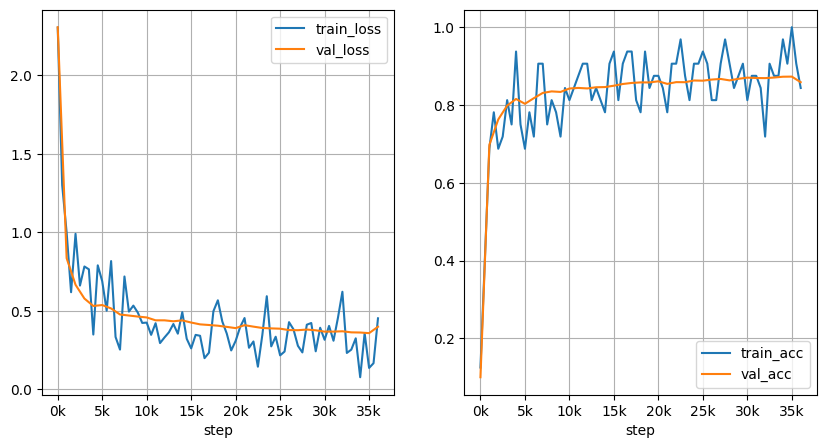

In [82]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")
    print(train_df.head())
    print(val_df.head())
    # plot
    fig_num = len(train_df.columns) #因为有loss和acc两个指标，所以画个子图
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5)) #fig_num个子图，figsize是子图大小
    for idx, item in enumerate(train_df.columns):    
        #index是步数，item是指标名字
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        x_data=range(0, train_df.index[-1], 5000) #每隔5000步标出一个点
        axs[idx].set_xticks(x_data)
        axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", x_data)) #map生成labal
        axs[idx].set_xlabel("step")
    
    plt.show()

plot_learning_curves(record, sample_step=500)  #横坐标是 steps

In [83]:
model = NeuralNetwork() # 重新定义模型
model = model.to(device)# 放到device上

In [84]:
model.load_state_dict(torch.load("checkpoints/best.ckpt", weights_only=True,map_location="cpu"))# 加载模型权重

model.eval()# 切换到验证集模式
loss, acc = evaluating(model, val_loader, loss_fct)# 评估模型
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")# 打印损失和准确率

loss:     0.3575
accuracy: 0.8730
